In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import keras
import pandas as pd

import sys
from pathlib import Path

from sklearn.preprocessing import StandardScaler

from keras import backend as K

Using TensorFlow backend.


In [2]:
## Change to your own path
path_photoz = "/jet/home/gvincent/encapZulate-1/src"

sys.path.insert(1, path_photoz)
path_photoz = Path(path_photoz)

In [3]:
from encapzulate.data_loader.data_loader import load_data
from encapzulate.utils.fileio import load_config

In [114]:
CONFIG_FILE = 'galen_CNN-baseline.yml'
config = load_config(path_photoz / "encapzulate" / "configs" / CONFIG_FILE, verbose = False)
config["input_shape"] = config["image_shape"]
config["num_gpus"] = 4
#config['dataset'] = 'satellite_images_dev'
#config['dataset_aux'] = 'tc_data_dev'
config['grid_scale'] = 4.0
config['hwhm'] = 150.0
config['eye_check'] = 'include'
config['dataloader'] = 'GOES'

#config["run_name"] = "test"
#config["epochs"] = 10
#config["learning_rate"] = 0.001
#config["batch_size"] = 300
#config["image_scale"] = 50.0
config

{'run_name': 'CNNbaseline',
 'num_gpus': 4,
 'compile_on': 'cpu',
 'path_data': '/ocean/projects/dms190029p/gvincent/tc-rmw-data',
 'dataset': 'satellite_images_clean',
 'dataset_aux': 'tc_data_clean',
 'dataloader': 'GOES',
 'image_shape': (200, 200, 1),
 'class_var': 'intensity',
 'eye_check': 'include',
 'num_class': 3,
 'max_year_train': 2016,
 'max_year_dev': 2018,
 'random_state': 200,
 'image_scale': 50.0,
 'class_weights': [1.0, 1.0, 1.0],
 'grid_scale': 4.0,
 'model_name': None,
 'routings': 3,
 'dim_capsule': 16,
 'batch_size': 200,
 'epochs': 100,
 'checkpoint': None,
 'learning_rate': 0.001,
 'decay_rate': 0.95,
 'lam_recon': 0.75,
 'hwhm': 150.0,
 'timeline': False,
 'path_results': None,
 'input_shape': (200, 200, 1)}

In [ ]:
((x_train, y_train, rmw_train, aux_train),
 (x_dev, y_dev, rmw_dev, aux_dev),
 (x_test, y_test, rmw_test, aux_test)) = load_data(**config)

In [6]:
x_train.shape

NameError: name 'x_train' is not defined

In [10]:
from scipy.stats import norm as normal

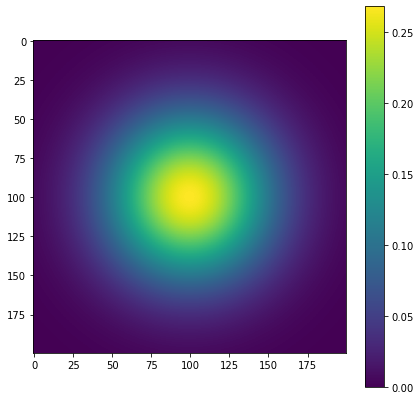

In [23]:
#weight_fn = lambda x: np.reciprocal(x)
#weight_fn = lambda x: np.exp(-0.0025*x)

hwhm = 175
gaus_scale = 2*hwhm/2.355 # Set HWHM to be equal to 100km

weight_fn = lambda x: normal.pdf(x, scale = gaus_scale) * 100
n_grid = (200, 200)
grid_scale = 4
y = np.linspace(-1*(n_grid[0] - 1)/2, (n_grid[0] - 1)/2, n_grid[0])
x = np.linspace(-1*(n_grid[1] - 1)/2, (n_grid[1] - 1)/2, n_grid[1])
xx, yy = np.meshgrid(x, np.flip(y))
dist_grid = np.sqrt(np.power(xx, 2) + np.power(yy, 2))
dist_km = dist_grid*grid_scale
weights = weight_fn(dist_km)
fig = plt.figure(figsize = (7, 7))
plt.imshow(weights, vmin = 0, vmax = np.max(weights))
plt.colorbar()
plt.show()

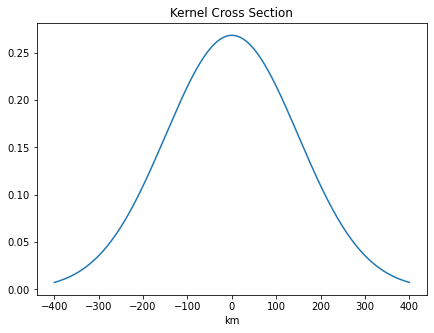

In [20]:
fig = plt.figure(figsize = (7, 5))
plt.plot(np.linspace(-400, 400, len(dist_km[100])), weight_fn(dist_km[100]))
plt.xlabel('km')
plt.title('Kernel Cross Section')
plt.show()

In [ ]:
## Up next is implementing data oversampling by following: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#oversampling
# Use the following code to perhaps create the needed dataset: https://stackoverflow.com/questions/64770484/issue-tf-data-dataset-for-keras-multi-input-model
# Remember to shuffle at the end and set "on each epoch" to true


In [120]:
a = load_GOES(**config)

In [ ]:
ebt_regression_data.wind = np.log(ebt_regression_data.wind)
ebt_regression_data.pressure_min = -1 * np.log(np.max(ebt_regression_data.pressure_min) + 5 - ebt_regression_data.pressure_min)
ebt_regression_data.distance = np.log(ebt_regression_data.distance)
ebt_regression_data = ebt_regression_data.to_numpy()
scaler = StandardScaler()
ebt_regression_data = scaler.fit_transform(ebt_regression_data)

In [121]:
a

,lat,lon,wind,pressure_min,distance
0,12.0,22.3,35.000000,1004.0,587.0
1,NaN,NaN,35.000000,NaN,NaN
2,NaN,NaN,35.000000,NaN,NaN
3,NaN,NaN,35.000000,NaN,NaN
4,NaN,NaN,35.000000,NaN,NaN
...,...,...,...,...,...
71590,NaN,NaN,36.666667,NaN,NaN
71591,NaN,NaN,36.250000,NaN,NaN
71592,NaN,NaN,35.833333,NaN,NaN
71593,NaN,NaN,35.416667,NaN,NaN


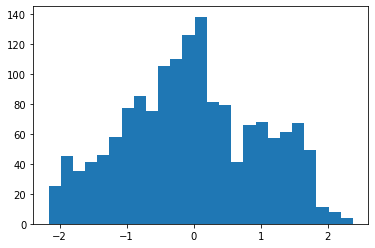

In [112]:
plt.hist(a[0][4][:,4], bins = 25)
plt.show()

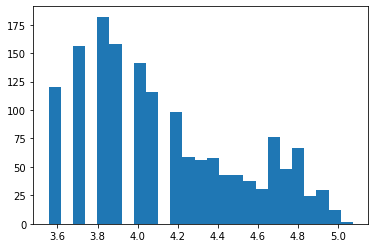

In [85]:
plt.hist(np.log(a[0][4][:,2]), bins = 25)
plt.show()

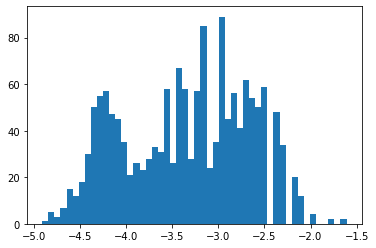

In [91]:
plt.hist(-1 * np.log(np.max(a[0][4][:,3]) + 5 - a[0][4][:,3]), bins = 50)
plt.show()

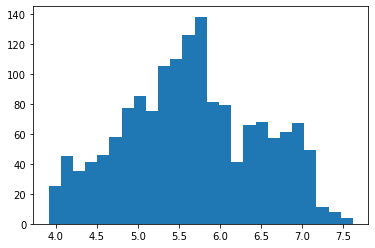

In [97]:
plt.hist(np.log(a[0][4][:,4]), bins = 25)
plt.show()

In [119]:
def load_GOES(
    num_class,
    path_data,
    max_year_train=2014,
    max_year_dev=2017,
    random_state=200,
    image_scale=1.0,
    class_var='intensity',
    eye_check='include',
    **params
):
    filename_imgs = f"{params['dataset']}.npy"
    filename_aux = f"{params['dataset_aux']}.csv"
    
    paths = [
        Path(path_data),
        Path("/ocean/projects/dms190029p/gvincent/tc-rmw-data")
    ]

    data_img = None
    data_tc = None
    
    for path in paths:
        try:
            data_img = np.load(str(path / filename_imgs), allow_pickle=True)
            data_tc = pd.read_csv(str(path / filename_aux), parse_dates=['date'], dtype={'ID': 'str', 
                                                                                         'time_idx': 'int32',
                                                                                         'wind': 'float64',
                                                                                         'eye_diam': 'float64',
                                                                                         'rmw': 'float64',
                                                                                         'atcf': 'int8',
                                                                                         'lat': 'float64',
                                                                                         'lon': 'float64',
                                                                                         'pressure_min': 'float64',
                                                                                         'distance': 'float64',
                                                                                         'type': 'str',
                                                                                         'pressure_outer': 'float64',
                                                                                         'radius_outer': 'float64',
                                                                                         'eye': 'int8',
                                                                                         'synoptic': 'int8',
                                                                                         'eye_10': 'int8',
                                                                                         'eye_20': 'int8',
                                                                                         'eye_30': 'int8',
                                                                                         'category': 'str',
                                                                                         'category_num': 'int8',
                                                                                         'nan_frac': 'float64',})
            break
        except FileNotFoundError:
            continue

    if (data_img is None) or (data_tc is None):
        raise FileNotFoundError
    
    eye_check_vals = data_tc.eye.to_numpy()
    
    if eye_check == 'include':
        pass
    elif eye_check == 'exclude':
        indices = np.argwhere(np.logical_or(eye_check_vals == 0, eye_check_vals == 1)).flatten()
        data_tc = data_tc.iloc[indices].reset_index(drop = True)
        data_img = data_img[indices]
    elif eye_check == 'return':
        indices = np.argwhere(eye_check_vals == -99).flatten()
        data_tc = data_tc.iloc[indices].reset_index(drop = True)
        data_tc['eye'] = 0
        data_img = data_img[indices]
    else:
        raise ValueError("eye_check is not one of 'exclude', or 'return' ")
    
    years = data_tc.date.dt.year.to_numpy()
    
    train_idx = np.argwhere(years <= max_year_train).flatten()
    dev_idx = np.argwhere((years > max_year_train) & (years <= max_year_dev)).flatten()
    test_idx = np.argwhere(years > max_year_dev).flatten()
    
    if class_var == 'intensity':
        category_labels = data_tc["category_num"].to_numpy()
    elif class_var == 'eye':
        category_labels = data_tc["eye"].to_numpy()
    else:
        raise ValueError("class_var is not one of 'intensity' or 'eye' ")
    
    category_labels = keras.utils.to_categorical(category_labels, num_classes=num_class)
    
    rmw = data_tc["rmw"].to_numpy()
    aux_data = data_tc
    
    # Get extra data for regression
    ebt_regression_data = aux_data[['lat', 'lon', 'wind', 'pressure_min', 'distance']].copy()
    
    return ebt_regression_data
    
    # Do some transfomations so these variables are approximately normal and unit variance
    ebt_regression_data.wind = np.log(ebt_regression_data.wind)
    ebt_regression_data.pressure_min = -1 * np.log(np.max(ebt_regression_data.pressure_min) + 5 - ebt_regression_data.pressure_min)
    ebt_regression_data.distance = np.log(ebt_regression_data.distance)
    ebt_regression_data = ebt_regression_data.to_numpy()
    scaler = StandardScaler()
    ebt_regression_data = scaler.fit_transform(ebt_regression_data)
    
    # Add extra dimension for image data to represent channels (remove if you actually have multiple channels):
    if len(data_img.shape) < 4:
        data_img = np.expand_dims(data_img, axis = 3)
    
    x_train = data_img[train_idx] / float(image_scale)
    x_dev = data_img[dev_idx] / float(image_scale)
    x_test = data_img[test_idx] / float(image_scale)

    y_train = category_labels[train_idx]
    y_dev = category_labels[dev_idx]
    y_test = category_labels[test_idx]

    rmw_train = rmw[train_idx]
    rmw_dev = rmw[dev_idx]
    rmw_test = rmw[test_idx]

    aux_train = aux_data.iloc[train_idx]
    aux_dev = aux_data.iloc[dev_idx]
    aux_test = aux_data.iloc[test_idx]
    
    ebt_train = ebt_regression_data[train_idx]
    ebt_dev = ebt_regression_data[dev_idx]
    ebt_test = ebt_regression_data[test_idx]
    
    return (
        (x_train, y_train, rmw_train, ebt_train, aux_train),
        (x_dev, y_dev, rmw_dev, ebt_dev, aux_dev),
        (x_test, y_test, rmw_test, ebt_test, aux_test),
    )